In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritwik/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/ritwik/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [38]:
import tokenizer 
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import pandas as pd
import numpy as np

tkzr = tokenizer.IncidentTokenizer(keep_onlyalphanumeric=True, stem_words=False, preserve_case=True, remove_stopwords=False)
wordnet_lemmatizer = WordNetLemmatizer()

text_fields = [
    'System.Title',
    'System.Tags',
    'System.Description',
    'Microsoft.VSTS.TCM.ReproSteps',
    'Microsoft.DevDiv.WalkThroughDescription'
]

use_less_noise = '<b>Affected Branch:</b> <br> <b>Affected Build:</b> <br> <b>Affected Product Language:</b> <br> <br><b>Steps to reproduce:</b><br> <br> 1.'

def handleCamelCase(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('_', ' ')

def getFieldRawText(wid):
    wit = all_wits[wid]
    fieldtext = ' '.join([wit.fields[f] if f in wit.fields and wit.fields[f] != use_less_noise else '' for f in text_fields])
    return preprocess(fieldtext)

stops = set(stopwords.words("english"))

def most_common(lst):
    return max(set(lst), key=lst.count)

def get_lemmas(words):
    lemmas = []
    for word in words:
        checkList=[wordnet_lemmatizer.lemmatize(word,'v'), wordnet_lemmatizer.lemmatize(word,'n'), wordnet_lemmatizer.lemmatize(word,'n')]
        lemmas.append(most_common(checkList))
    return lemmas
    
def preprocess(fieldtext):
    tokens = tkzr.tokenize(fieldtext)
    fieldtext=' '.join([handleCamelCase(t) for t in tokens if not str.isdigit(t)])
    words = fieldtext.split()
    words = [w for w in words if not w in stops and len(w)>1]
    return ' '.join([lemma for lemma in get_lemmas(words) if len(lemma)>1])

In [39]:
with open('SampleText.txt', 'r') as myfile:
    test_string=myfile.read().replace('\n', '')

In [40]:
test_string

'<body contenteditable="true" role="textbox" aria-multiline="true" aria-label="Repro Steps" data-gramm_id="70cc6bdc-8973-5368-13dc-d60f9f42bf07" data-gramm="true" spellcheck="false" data-gramm_editor="true"><p class="MsoNormal" style="word-break:break-all;"></p><p style="box-sizing:border-box;margin:0in 0in 0pt;color:rgb(51, 51, 51);font-family:"Segoe UI", "Helvetica Neue", Helvetica, Arial, sans-serif;font-size:13px;"><span style="box-sizing:border-box;color:rgb(31, 73, 125);font-family:Calibri, sans-serif;font-size:11pt;">\xa0</span></p><p></p><p style="box-sizing:border-box;margin:0in 0in 0pt;color:rgb(51, 51, 51);font-family:"Segoe UI", "Helvetica Neue", Helvetica, Arial, sans-serif;font-size:13px;"><span style="box-sizing:border-box;color:rgb(31, 73, 125);font-family:Calibri, sans-serif;font-size:11pt;">TF400797: Job extension had an unhandled error: Microsoft.TeamFoundation.Framework.Server.TeamFoundationServicingException: TF400711: Error occurred while executing servicing step 

In [41]:
cleaned_text = preprocess(test_string)

In [42]:
cleaned_text

'tf400797 job extension unhandled error microsoft team foundation framework server team foundation servicing exception tf400711 error occurred executing servicing step create team project component project create tfs integration project create error rebuild caller view connecting domain user could validated system data sql client sql exception error rebuild caller view connecting domain user could validated microsoft team foundation framework server team foundation sql resource component map exception sql exception ex query execution state query state v2 a1 work vssf sdk server component team foundation sql resource component line microsoft team foundation framework server team foundation sql resource component handle exception exception exception v2 a1 work vssf sdk server component team foundation sql resource component line microsoft team foundation framework server team foundation sql resource component execute command execute type execute type command behavior behavior string perf

In [43]:
%%time
import pickle

with open("raw_data.pickle", "rb") as raw_data:
    all_wits = pickle.load(raw_data)

Wall time: 25.4 s


In [44]:
def filter_work_item(id):
    if id<400000:
        return True
    if 'eprecated' in all_wits[id].fields['System.AreaPath']:
        return True
    if all_wits[id].fields['System.TeamProject'] == 'VSOnline':
        return False
    return True

ids = [wid for wid in all_wits if not filter_work_item(wid)]
print(len(ids))

191278


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


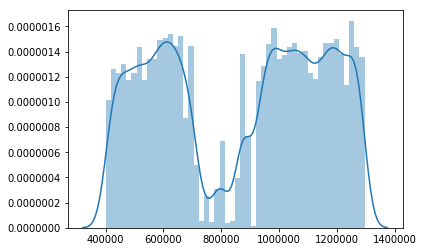

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(ids)

In [46]:
len([id for id in ids if id>400000])

191277

In [47]:

def get_text(id):
    return getFieldRawText(wid=id)

In [48]:
get_text(120)

'testa'

In [49]:
all_wits[120].fields['Microsoft.VSTS.TCM.ReproSteps']

'<b>Affected Branch:</b> <br> <b>Affected Build:</b> <br> <b>Affected Product Language:</b> <br> <br><b>Steps to reproduce:</b><br> <br> 1.'

In [50]:
def get_area(id):
    return all_wits[id].fields['System.AreaPath']

get_area(54052)

'VSOnline\\VSTS\\CI and Web Platform'

In [51]:
def get_area_id(id):
    return all_wits[id].fields['System.AreaId']

get_area_id(54052)

15285

In [53]:
get_text(54052)

'annotate break nre customer git keep item filed customer please communicate close loop customer via customer tab inside tfs problem description step reproduce open solutuion repository based existing oldish github repo right click source file select source control annotate expected source file annotated link change set actual nre microsoft visual studio team foundation error object reference set instance object ok attached screenshot issue happen every file repo'

In [54]:
def get_work_item_type(id):
    return all_wits[id].fields['System.WorkItemType']
    

In [55]:
len(ids)

191278

In [64]:
%%time
# data frame id, area, area id, work item type, text
wit_ids = [id for id in ids]
wit_texts = [get_text(id) for id in wit_ids]
wit_area_paths = [get_area(id) for id in wit_ids]
wit_area_ids = [get_area_id(id) for id in wit_ids]
wit_types = [get_work_item_type(id) for id in wit_ids]
d = {'id': wit_ids, 'area_path': wit_area_paths, 'area_id': wit_area_ids, 'type': wit_types, 'text': wit_texts}
df = pd.DataFrame(d)

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.    '" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.    '" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Wall time: 17min 31s


In [65]:
df

,id,area_path,area_id,type,text
0,400000,VSOnline\VSTS\Marketplace,16286,User Story,landing page finalize footer landing page spec...
1,400001,VSOnline\VSTS\Marketplace,16286,User Story,marketing identify avenue market cross link ma...
2,400002,VSOnline\VSTS\Marketplace,16286,User Story,documentation update documentation msdn reflec...
3,400003,VSOnline\VSTS\Version Control\VC Workflows,16251,Bug,te pull request page show rejected status even...
4,400007,VSOnline\VSTS\Agile\WIT Z,4156,Bug,query vso context needed vendor query file tfs...
5,400009,VSOnline\VSTS\Shared Cloud Services\Subscriptions,12991,DTS Task,changing mail address msdn subscriber answered...
6,400010,VSOnline\VSTS\Version Control\VC Desktop,19280,Feature,msscci support dev15 visual studio
7,400012,VSOnline\VSTS\Version Control\VC Desktop,19280,User Story,engineer want work msscci code mseng devdiv qu...
8,400013,VSOnline\VSTS\Version Control\VC Workflows,16251,Bug,te pull request tooltip need enhancement updat...
9,400014,VSOnline\VSTS\Version Control\VC Desktop,19280,User Story,team want understand loading performance key v...


In [66]:
with open('cleaned_over400000_total191278_data.pickle', 'wb') as handle:
    pickle.dump(df, handle)